# SBML import

[SBML](https://sbml.org) is a free and open data format for describing models in computational systems biology. This notebook illustrates how the SBML format can be used together the simulation toolboxes [RoadRunner](https://libroadrunner.readthedocs.io/en/latest/index.html): "The Roadrunner Simulation Engine is a C++ library for simulating and analysing systems of differential equations. Roadrunner was designed with performance as a priority and is an exceptionally fast simulator." However, there are many different simulators out there, which might be more suitable for the defined model, such as [AMICI](https://amici.readthedocs.io/en/latest/), which can also be easily used in a similar way.

To follow this notebook, you need to have (at least) BayesFlow and RoadRunner installed. You can install all via:

    pip install bayesflow libroadrunner

In [1]:
# install if not done yet
!pip install libroadrunner --quiet

In [2]:
import numpy as np
import roadrunner

import bayesflow as bf

/Users/jonas.arruda/miniconda/envs/EMUNE/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Import an SBML Model to BayesFlow


First, we read the SBML model, create a roadrunner model and then import it in BayesFlow. You can either read a local file or use a model from the BioModels database: a repository of mathematical models of biological and biomedical systems. Roadrunner can handle stochastic or deterministic models. Here, as an example, we use the model [Cell-to-cell variability in JAK2/STAT5 pathway](https://www.ebi.ac.uk/biomodels/BIOMD0000001077#Overview) from Adlung et al. (2021).


In [3]:
# read the sbml model

# you can either read a local file
# sbml_file = 'example_model.xml'

# or download it from BioModels: a repository of mathematical models of biological and biomedical systems
sbml_model_url = (
    "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000001077?filename=Adlung2021%20_model_jakstat_pa.xml"
)

# sometimes roadrunner has problems with the ssl certificate, you can ignore it by
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

rr = roadrunner.RoadRunner(sbml_model_url)

In [4]:
# switching between an ODE simulation and a stochastic simulation is as easy as
# rr.setIntegrator('gillespie')

Now that we have the model, we need to specify which states of the model are observed and which parameters we want to estimate.

In [5]:
observed_species = ["Total_STAT5", "measuralbe_pSTAT5"]
params = ["init_EpoRJAK2", "init_SHP1", "init_STAT5"]
# all other parameters are fixed to their default values defined in the SBML model

In [6]:
sim = rr.simulate(0, 300, 100, selections=["time"] + observed_species)
rr.reset()

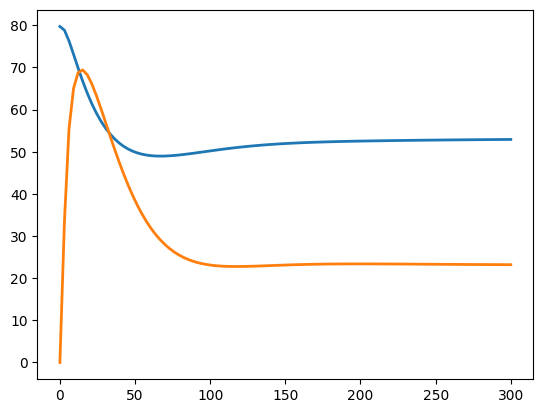

In [7]:
rr.plot();

## Define the Generative Model

We can now define the generative model for BayesFlow. The generative model is a combination of a simulator and a prior. The simulator is a function that takes a batch of parameter values from the prio and returns a batch of simulated data. The generative model is used to generate synthetic data for training the amortized posterior. Since we are using a deterministic simulator, we need to define a noise model for the observations. Here, we assume additive independent normal noise on the observations. The noise parameters are added to the parameter vector and are estimated by BayesFlow.

In [8]:
def sbml_simulator(param_batch, simulation_duration=300):
    # this can either be set once, or vary per simulation batch
    eval_points = np.random.randint(5, 150)
    # set the observed species
    rr.timeCourseSelections = observed_species
    out = np.zeros((len(param_batch), eval_points, len(observed_species)), dtype=np.float32)
    for batch_id, param_values in enumerate(param_batch):
        # we have to reset the model to the original state
        rr.reset()
        # give roadrunner the current parameters and simulate
        for param_id, p in enumerate(params):
            rr[p] = param_values[param_id]
        # simulate the model with the current parameters
        out[batch_id] = rr.simulate(0, simulation_duration, eval_points)
        # add noise on observations (assuming additive independent normal noise here)
        sigmas = param_values[-len(observed_species) :]
        out[batch_id] += np.random.multivariate_normal(
            mean=np.zeros(len(observed_species)), cov=np.diag(sigmas), size=eval_points
        )
    return out


# create BayesFlow Simulation object
simulator = bf.simulation.Simulator(batch_simulator_fun=sbml_simulator)

We now have to define our prior, which is not encoded in the SBML model. For every parameter, which we like to estimate, we define a prior distribution. All other parameters will be fixed to their default values defined in the SBML model.

In [9]:
# build the prior
lower_bounds = [0] + [0] * len(observed_species)
upper_bounds = [10] + [10] * len(observed_species)
prior = bf.simulation.Prior(
    batch_prior_fun=lambda batch_size: np.random.uniform(
        low=lower_bounds, high=upper_bounds, size=(batch_size, len(lower_bounds))
    ),
    param_names=["theta1"] + [f"sigma_{name}" for name in observed_species],
)

In [10]:
model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator, name=rr.getModelName())

INFO:root:Performing 2 pilot runs with the Adlung2021 - Cell-to-cell variability in JAK2/STAT5 pathway model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 95, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


## Train BayesFlow

Now we can define the neural networks and train BayesFlow on simulated data.

In [11]:
summary_net = bf.networks.SequenceNetwork(summary_dim=10)

In [12]:
inference_net = bf.networks.InvertibleNetwork(
    num_params=len(params),
    num_coupling_layers=4,
    coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": False},
)

In [13]:
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

In [14]:
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [15]:
%%time
history = trainer.train_online(epochs=3, iterations_per_epoch=100, batch_size=32, validation_sims=100)

INFO:root:Generated 100 simulations for validation.


Training epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 7.405


Training epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 7.390


Training epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 7.412


CPU times: user 28.1 s, sys: 3.58 s, total: 31.7 s
Wall time: 26.4 s


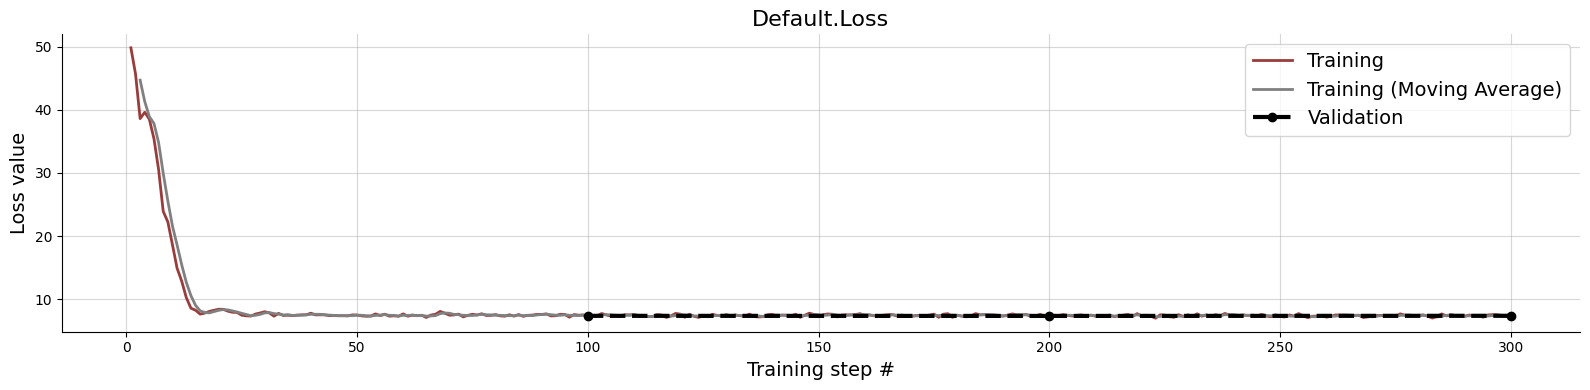

In [16]:
f = bf.diagnostics.plot_losses(history["train_losses"], history["val_losses"], moving_average=True)

At this point you should validate the consistency of your trained amortizer and check out the calibration using the SBC technique. You can follow the intro [tutorial](https://bayesflow.org/_examples/Intro_Amortized_Posterior_Estimation.html) for this.

## Inference Phase
Once the approximator has passed all consistency checks, we can now go ahead and apply it to real data!